# Resnet 18 on faces 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
import resnet


In [2]:
batchsize = 75
rate = 0.15
epochs = 150
lr_decay = 0.84
lr_stride = 5

In [3]:
class FaceDataset(torch.utils.data.Dataset):

    def __init__(self, transform, train=True):
        self.image_prefix = "face_renders/face"
        self.image_suffix = ".jpg"
        self.vertex_prefix = "processed_faces/face"
        self.vertex_suffix = ".txt"
        self.count = 5000
        self.trainn = 4500
        
        self.train = train
        self.transform = transform
        
        shape = np.loadtxt(self.vertex_prefix + str(1) + self.vertex_suffix).shape
        tmp = np.zeros((self.count, shape[0], shape[1]))
        for i in range(self.count):
            tmp[i] = np.loadtxt(self.vertex_prefix + str(i + 1) + self.vertex_suffix)
            
        self.mean = np.mean(tmp, axis=0)
        self.outputdim = shape[0] * shape[1]
        self.labels = [torch.from_numpy((lab - self.mean).reshape(self.outputdim)).float() for lab in tmp]
        
        self.images = [plt.imread(self.image_prefix + str(i + 1) + self.image_suffix) for i in range(self.count)]
            
        # simple version for working with CWD
        

    def __len__(self):
        if self.train:
            return self.trainn
        else:
            return self.count - self.trainn

    def __getitem__(self, idx):
        if not self.train:
            idx += self.trainn
        return (self.transform(self.images[idx]), self.labels[idx])

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = FaceDataset(transform, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)

testset = FaceDataset(transform, train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,
                                          shuffle=False, num_workers=0)


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("torch.cuda.is_available()   =", torch.cuda.is_available())
print("torch.cuda.device_count()   =", torch.cuda.device_count())
print("torch.cuda.device('cuda')   =", torch.cuda.device(0))
print("torch.cuda.current_device() =", torch.cuda.current_device())

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)
    
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

torch.cuda.is_available()   = True
torch.cuda.device_count()   = 1
torch.cuda.device('cuda')   = <torch.cuda.device object at 0x000001CBBBB565F8>
torch.cuda.current_device() = 0


In [6]:
model = resnet.resnet101(output_size=trainset.outputdim)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=rate)

criterion = nn.MSELoss()

def adjust_learning_rate(optimizer, epoch, decay, stride):
    lr = rate * (decay ** (epoch // stride))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [7]:
def train(model, optimizer, criterion, epochs, trainloader, testloader):
    model.train()
    samples = 1
    losses = []
#     test_losses = []
    k = len(trainloader)// samples
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % k == k - 1:

                losses.append(running_loss / k)
                
#                 testloss = 0
#                 total = 0
#                 iterations = 0
#                 with torch.no_grad():
#                     for data in testloader:
#                         images, labels = data
#                         outputs = model(images)
#                         testloss += criterion(outputs, labels)
#                         total += labels.size(0)
#                         iterations += 1
#                         if total > 200:
#                             break
#                 test_losses.append(testloss / iterations)
                
                print('[%d, %5d] loss: %.3f test_loss: %.3f' %(epoch + 1, i + 1,losses[-1], 0)) #test_losses[-1]

                running_loss = 0.0
                
        adjust_learning_rate(optimizer, epoch+1, lr_decay, lr_stride)

    print('Finished Training')
    plt.plot(np.arange(0, len(losses)/samples, 1.0/samples), losses)
    plt.title("loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
    
#     plt.plot(np.arange(0, len(test_losses)/samples, 1.0/samples), test_losses)
#     plt.title("test_loss")
#     plt.xlabel("epoch")
#     plt.ylabel("test_losses")
#     plt.show()
    model.eval()


[1,    60] loss: 9.569 test_loss: 0.000
[2,    60] loss: 7.261 test_loss: 0.000
[3,    60] loss: 5.850 test_loss: 0.000
[4,    60] loss: 5.102 test_loss: 0.000
[5,    60] loss: 4.678 test_loss: 0.000
[6,    60] loss: 4.331 test_loss: 0.000
[7,    60] loss: 4.106 test_loss: 0.000
[8,    60] loss: 3.800 test_loss: 0.000
[9,    60] loss: 3.597 test_loss: 0.000
[10,    60] loss: 3.415 test_loss: 0.000
[11,    60] loss: 3.188 test_loss: 0.000
[12,    60] loss: 3.043 test_loss: 0.000
[13,    60] loss: 2.940 test_loss: 0.000
[14,    60] loss: 2.839 test_loss: 0.000
[15,    60] loss: 2.765 test_loss: 0.000
[16,    60] loss: 2.592 test_loss: 0.000
[17,    60] loss: 2.475 test_loss: 0.000
[18,    60] loss: 2.401 test_loss: 0.000
[19,    60] loss: 2.340 test_loss: 0.000
[20,    60] loss: 2.290 test_loss: 0.000
[21,    60] loss: 2.206 test_loss: 0.000
[22,    60] loss: 2.147 test_loss: 0.000
[23,    60] loss: 2.116 test_loss: 0.000
[24,    60] loss: 2.048 test_loss: 0.000
[25,    60] loss: 2.009 t

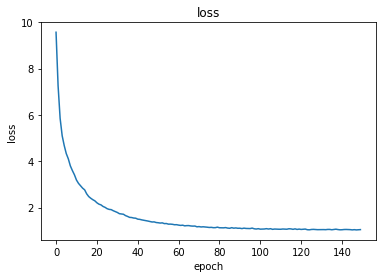

In [8]:
train(model, optimizer, criterion, epochs, trainloader, testloader)

In [10]:
torch.save(model.state_dict(), "res101b" + str(batchsize) + "r" + str(rate) + "e" + str(epochs) + ".statedict")

In [12]:
with torch.no_grad():
    d = next(testloader.__iter__())
    images, labels = d
    outputs = model(images)
    
    print(trainset.mean)
    print(outputs[0])
    print(labels[0])
    print(np.linalg.norm((labels[0] - outputs[0]).to('cpu').numpy()))
    

[[-57.42849171  43.50585649  81.09827847]
 [-57.10330025  40.76217867  80.77729131]
 [-56.4013172   36.99098729  79.87123442]
 ...
 [ 54.11570628 -43.99206555  66.38817782]
 [ 55.6071899  -46.20434955  60.50756982]
 [ 56.74632444 -47.9137754   53.69290953]]
tensor([-2.2968, -2.0359,  5.6980,  ...,  7.2326, -1.8773,  1.3138], device='cuda:0')
tensor([-2.9954, -1.1436,  5.3742,  ...,  6.9024, -1.8781,  1.2504], device='cuda:0')
48.44615


In [ ]:
np.mean(np.std([l.numpy() for l in trainset.labels], axis=0))

In [6]:
model = resnet.resnet101(output_size=trainset.outputdim)
model.load_state_dict(torch.load("res101b75r0.15e150.statedict"))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [16]:
running_loss = 0
criterion = nn.MSELoss()
start = 4501
for i, data in enumerate(testloader, 0):
    # get the inputs
    inputs, labels = data

    # forward + backward + optimize
    outputs = model(inputs)
    
    for o in outputs:
        arr = o.detach().to("cpu").numpy().reshape((564,3)) + testset.mean
        
        np.savetxt("predictions/face" + str(start) + ".txt", arr, fmt="%.9f")
        start += 1
    
    loss = criterion(outputs, labels)

    # print statistics
    running_loss += loss.item()
    
print(running_loss / 500 * 75 * 564)

1712.0628659248353


In [11]:
print (len(testloader))

60
